In [21]:
!pip install scikit-fuzzy

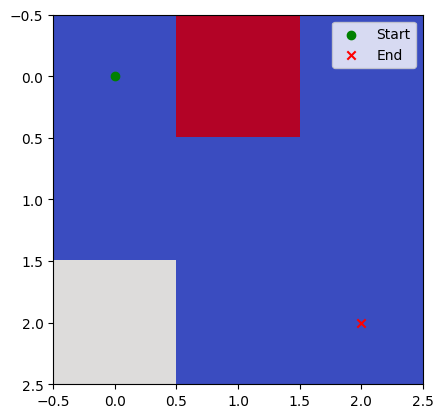

Initial Position: (0, 0)
New Position: (0, 0)


In [33]:
#robot navigation using BPA and fuzzy logic

import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import skfuzzy as fuzz
import skfuzzy.control as ctrl


class GridEnvironment:
    def __init__(self, size=(3,3), start=(0,0), end=(2,2)):
        self.size = size
        self.start = start
        self.end = end
        self.grid = np.zeros(size)
        self.static_obstacles = []
        self.dynamic_obstacles = []
        self.place_static_obstacles()

    def place_static_obstacles(self, count=1):
        while len(self.static_obstacles) < count:
            r = random.randint(0, self.size[0]-1)
            c = random.randint(0, self.size[1]-1)
            if (r, c) not in [self.start, self.end] and self.grid[r, c] == 0:
                self.grid[r, c] = 1
                self.static_obstacles.append((r, c))

    def update_dynamic_obstacles(self):
        # Clear previous dynamic obstacles
        for pos in self.dynamic_obstacles:
            self.grid[pos] = 0
        self.dynamic_obstacles.clear()

        # Add new dynamic obstacles
        count = 1
        while len(self.dynamic_obstacles) < count:
            r = random.randint(0, self.size[0]-1)
            c = random.randint(0, self.size[1]-1)
            if (r, c) not in [self.start, self.end] and self.grid[r, c] == 0:
                self.grid[r, c] = 2
                self.dynamic_obstacles.append((r, c))

    def display_grid(self, path=None):
        plt.imshow(self.grid, cmap='coolwarm', origin='upper')
        plt.scatter(self.start[1], self.start[0], marker='o', color='green', label='Start')
        plt.scatter(self.end[1], self.end[0], marker='x', color='red', label='End')
        if path:
            for p in path:
                plt.scatter(p[1], p[0], marker='.', color='yellow')
        plt.legend()
        plt.show()



class RobotAgent:
    def __init__(self, environment):
        self.env = environment
        self.position = environment.start
        self.path = [self.position]

    def move(self, direction):
        deltas = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}
        if direction in deltas:
            new_pos = (self.position[0] + deltas[direction][0], self.position[1] + deltas[direction][1])
            if (0 <= new_pos[0] < self.env.size[0] and
                0 <= new_pos[1] < self.env.size[1] and
                self.env.grid[new_pos] == 0):
                self.position = new_pos
                self.path.append(new_pos)
                return True
        return False


    def _is_valid_move(self, pos):
        if (0 <= pos[0] < self.env.size[0]) and (0 <= pos[1] < self.env.size[1]):
            if pos not in self.env.static_obstacles and pos not in self.env.dynamic_obstacles:
                return True
        return False


env = GridEnvironment(size=(3, 3), start=(0, 0), end=(2, 2))
env.update_dynamic_obstacles()
env.display_grid()


robot = RobotAgent(env)
print("Initial Position:", robot.position)
#robot.move('right')
print("New Position:", robot.position)




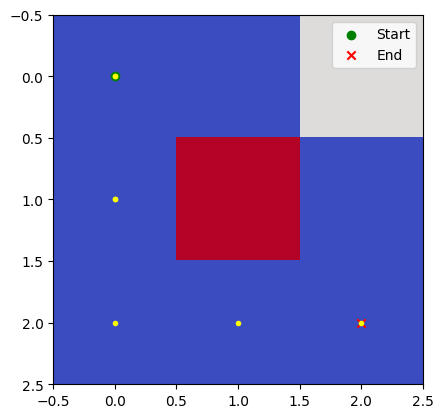

In [39]:
# Backpropagation Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

class BackpropagationPathfinder:
    def __init__(self, input_dim=6, output_dim=4):
        self.model = Sequential([
            Dense(16, activation='relu', input_shape=(input_dim,)),
            Dense(16, activation='relu'),
            Dense(output_dim, activation='softmax')
        ])
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, X, y, epochs=100):
        self.model.fit(np.array(X), np.array(y), epochs=epochs, verbose=0)

    def predict_direction(self, input_data):
        output = self.model.predict(np.array([input_data]), verbose=0)
        direction_index = np.argmax(output)
        return ['up', 'down', 'left', 'right'][direction_index]

def generate_training_data(env, samples=100):
  X = []
  y = []
  directions = {'up': [1, 0, 0, 0], 'down': [0, 1, 0, 0], 'left': [0, 0, 1, 0], 'right': [0, 0, 0, 1]}

  for _ in range(samples):
        env.update_dynamic_obstacles()
        r, c = random.randint(0, 2), random.randint(0, 2)
        if env.grid[r, c] != 0 or (r, c) == env.end:
            continue
        dist = np.linalg.norm(np.array(env.end) - np.array((r, c)))
        obs = 0
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < env.size[0] and 0 <= nc < env.size[1] and env.grid[nr, nc] != 0:
                obs += 1
        if env.end[0] > r:
            target = 'down'
        elif env.end[0] < r:
            target = 'up'
        elif env.end[1] > c:
            target = 'right'
        else:
            target = 'left'

        X.append([r, c, env.end[0], env.end[1], dist, obs])
        y.append(directions[target])
  return X, y


env_bpa = GridEnvironment(size=(3, 3), start=(0, 0), end=(2, 2))
bpa_model = BackpropagationPathfinder()
X_train, y_train = generate_training_data(env_bpa, samples=100)
bpa_model.train(X_train, y_train, epochs=100)

# Run BPA-based navigation
robot_bpa = RobotAgent(env_bpa)
max_steps = 100
for step in range(max_steps):
    if robot_bpa.position == env_bpa.end:
        break
    env_bpa.update_dynamic_obstacles()
    r, c = robot_bpa.position
    dist = np.linalg.norm(np.array(env_bpa.end) - np.array((r, c)))
    obs = 0
    for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
        nr, nc = r + dr, c + dc
        if 0 <= nr < env_bpa.size[0] and 0 <= nc < env_bpa.size[1] and env_bpa.grid[nr, nc] != 0:
            obs += 1
    input_data = [r, c, env_bpa.end[0], env_bpa.end[1], dist, obs]
    direction = bpa_model.predict_direction(input_data)
    moved = robot_bpa.move(direction)
    if not moved:
        for d in ['up', 'down', 'left', 'right']:
            if robot_bpa.move(d):
                break

else:
    print("Could not reach the goal within step limit.")

env_bpa.display_grid(path=robot_bpa.path)

Reached the goal in 0 steps!


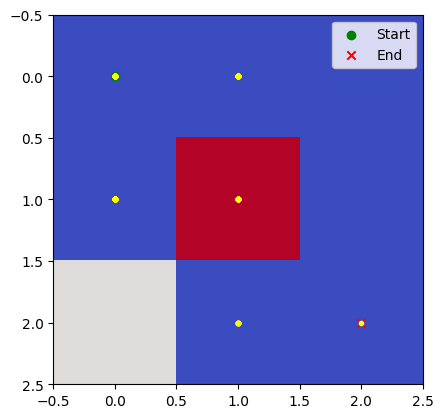

In [40]:
# Fuzzy Logic System for Movement
class FuzzyPathfinder:
    def __init__(self):
        self.distance = ctrl.Antecedent(np.arange(0, 5, 1), 'distance')
        self.obstacle = ctrl.Antecedent(np.arange(0, 2, 1), 'obstacle')
        self.direction = ctrl.Consequent(np.arange(0, 4, 1), 'direction')

        self.distance['near'] = fuzz.trimf(self.distance.universe, [0, 0, 4])
        self.distance['far'] = fuzz.trimf(self.distance.universe, [3, 10, 10])

        self.obstacle['low'] = fuzz.trimf(self.obstacle.universe, [0, 0, 2])
        self.obstacle['high'] = fuzz.trimf(self.obstacle.universe, [1, 4, 4])

        self.direction['left'] = fuzz.trimf(self.direction.universe, [0, 0, 1])
        self.direction['right'] = fuzz.trimf(self.direction.universe, [2, 3, 3])
        self.direction['up'] = fuzz.trimf(self.direction.universe, [0, 1, 2])
        self.direction['down'] = fuzz.trimf(self.direction.universe, [1, 2, 3])

        rule1 = ctrl.Rule(self.distance['near'] & self.obstacle['low'], self.direction['right'])
        rule2 = ctrl.Rule(self.distance['far'] & self.obstacle['low'], self.direction['down'])
        rule3 = ctrl.Rule(self.distance['near'] & self.obstacle['high'], self.direction['left'])
        rule4 = ctrl.Rule(self.distance['far'] & self.obstacle['high'], self.direction['up'])

        self.control_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def get_direction(self, dist, obs):
        self.simulation.input['distance'] = dist
        self.simulation.input['obstacle'] = obs
        self.simulation.compute()
        fuzzy_output = self.simulation.output['direction']
        direction_index = int(round(fuzzy_output))
        return ['left', 'down', 'right', 'up'][direction_index % 4]

max_steps = 1000
for step in range(max_steps):
    if robot.position == env.end:
        print("Reached the goal in", step, "steps!")
        break

    env.update_dynamic_obstacles()

    # Calculate distance to goal
    current_pos = robot.position
    goal_pos = env.end
    distance_to_goal = np.linalg.norm(np.array(goal_pos) - np.array(current_pos))

    # Count nearby obstacles
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    obstacle_count = 0
    for dr, dc in neighbors:
        nr, nc = current_pos[0] + dr, current_pos[1] + dc
        if 0 <= nr < env.size[0] and 0 <= nc < env.size[1] and env.grid[nr, nc] != 0:
            obstacle_count += 1

    # Get fuzzy direction
    fuzzy_direction = fuzzy_model.get_direction(distance_to_goal, obstacle_count)
    moved = robot.move(fuzzy_direction)
    if not moved:
        #print("Blocked. Trying random move.")
        for d in ['up', 'down', 'left', 'right']:
            if robot.move(d):
                break

else:
    print("Could not reach the goal within step limit.")

# Final display
env.display_grid(path=robot.path)


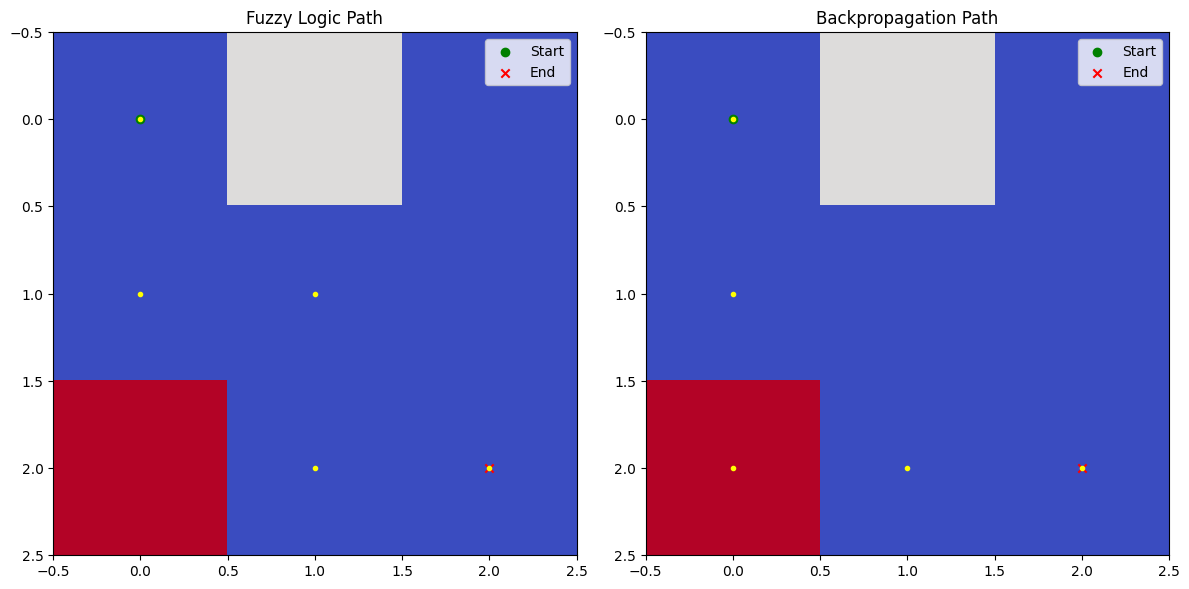

In [45]:
#comparision of BPA and FIS

def compare_paths():
    # Initialize environment
    env = GridEnvironment(size=(3, 3), start=(0, 0), end=(2, 2))

    # Fuzzy Path (simple greedy rule-based)
    fuzzy_robot = RobotAgent(env)
    for _ in range(100):
        if fuzzy_robot.position == env.end:
            break
        env.update_dynamic_obstacles()
        r, c = fuzzy_robot.position
        options = []
        for d, (dr, dc) in {'up':(-1,0), 'down':(1,0), 'left':(0,-1), 'right':(0,1)}.items():
            nr, nc = r + dr, c + dc
            if 0 <= nr < env.size[0] and 0 <= nc < env.size[1] and env.grid[nr, nc] == 0:
                distance = np.linalg.norm(np.array((nr, nc)) - np.array(env.end))
                options.append((distance, d))
        if options:
            options.sort()
            fuzzy_robot.move(options[0][1])

    fuzzy_path = fuzzy_robot.path

    # BPA path
    bpa_robot = RobotAgent(env)
    bpa_model = BackpropagationPathfinder()
    X_train, y_train = generate_training_data(env, samples=200)
    bpa_model.train(X_train, y_train, epochs=150)

    for step in range(100):
        if bpa_robot.position == env.end:
            break
        env.update_dynamic_obstacles()
        r, c = bpa_robot.position
        dist = np.linalg.norm(np.array(env.end) - np.array((r, c)))
        obs = 0
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < env.size[0] and 0 <= nc < env.size[1] and env.grid[nr, nc] != 0:
                obs += 1
        input_data = [r, c, env.end[0], env.end[1], dist, obs]
        direction = bpa_model.predict_direction(input_data)
        moved = bpa_robot.move(direction)
        if not moved:
            for d in ['up', 'down', 'left', 'right']:
                if bpa_robot.move(d):
                    break

    bpa_path = bpa_robot.path

    # Plot side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    for ax, path, title in zip(axs, [fuzzy_path, bpa_path], ['Fuzzy Logic Path', 'Backpropagation Path']):
        ax.imshow(env.grid, cmap='coolwarm', origin='upper')
        ax.scatter(env.start[1], env.start[0], marker='o', color='green', label='Start')
        ax.scatter(env.end[1], env.end[0], marker='x', color='red', label='End')
        for p in path:
            ax.scatter(p[1], p[0], marker='.', color='yellow')
        ax.set_title(title)
        ax.legend()
    plt.tight_layout()
    plt.show()

compare_paths()
